# TFM

##1. Configuacion

In [22]:
# ============================================================
# 1. Configuración del entorno
# ============================================================

# Instalación de librerías necesarias
!pip install --quiet pyeph scikit-learn openpyxl shap

In [23]:
# ============================================================
# 2. Importación de librerías
# ============================================================

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt

# EPH
import pyeph

# Modelado y evaluación
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score,
    classification_report, confusion_matrix
)

# Modelos lineales
from sklearn.linear_model import (
    LassoCV, RidgeCV, ElasticNetCV, LogisticRegression
)

# Modelos no lineales
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC

# Interpretabilidad con SHAP
import shap
shap.initjs()
from IPython.display import display

##2. Extraer bases de datos
Se utiliza la libreria [pyeph](https://pypi.org/project/pyeph/)

In [24]:
# ============================================================
# 3. Descarga y carga de datos EPH
# ============================================================

# Diccionarios para almacenar las bases
bases_individuales = {}
bases_hogar = {}

# Año y trimestre a descargar
año = 2023
trimestre = 4
clave = f"{año}T{trimestre}"

# Descarga de base individual
try:
    bases_individuales[clave] = pyeph.obtener(
        data="eph", ano=año, periodo=trimestre, tipo_base="individual"
    )
    print(f"✓ Base individual {clave} descargada")
except Exception as e:
    print(f"✗ Error en base individual {clave}: {e}")

# Descarga de base de hogar
try:
    bases_hogar[clave] = pyeph.obtener(
        data="eph", ano=año, periodo=trimestre, tipo_base="hogar"
    )
    print(f"✓ Base hogar {clave} descargada")
except Exception as e:
    print(f"✗ Error en base hogar {clave}: {e}")

Obtenido con exito: base_individual_2023T4.zip 
✓ Base individual 2023T4 descargada
Obtenido con exito: base_hogar_2023T4.zip 
✓ Base hogar 2023T4 descargada


In [25]:
# ============================================================
# 4. Exportación de bases a Excel (4º trimestre 2023)
# ============================================================

# Clave del período a exportar
clave = "2023T4"

# Exportar base individual
#df_individual = bases_individuales[clave].copy()
#df_individual.to_excel(f"base_individual_{clave}.xlsx", index=False)

# Exportar base hogar
#df_hogar = bases_hogar[clave].copy()
#df_hogar.to_excel(f"base_hogar_{clave}.xlsx", index=False)

##3. Procesar datos

###3.1 Crear bases

In [26]:
# ============================================================
# 5. Procesamiento de la base HOGAR (4º trimestre 2023)
# ============================================================

# Clave del período
clave = "2023T4"

# Variables de interés y variables finales a conservar
variables_hogar_interes = [
    'CODUSU', 'NRO_HOGAR', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO',
    'PONDERA', 'PONDIH', 'IX_TOT', 'IPCF',
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11',
    'IV12_1', 'IV12_2', 'IV12_3',
    'II1', 'II2', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II7', 'II8', 'II9',
    'V1', 'V2', 'V7', 'V8', 'V9', 'V10', 'V19_A', 'V19_B',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

variables_finales = [
    'CODUSU', 'REGION', 'AGLOMERADO',
    'PONDERA', 'PONDIH', 'IX_TOT', 'IPCF',
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11',
    'IV12_1', 'IV12_2', 'IV12_3',
    'II1', 'II2', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II7', 'II8', 'II9',
    'V1', 'V2', 'V7', 'V8', 'V9', 'V10', 'V19_A', 'V19_B',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

# Carga y filtrado inicial
df_hogar = bases_hogar[clave][variables_hogar_interes].copy()
df_hogar = df_hogar[variables_finales].copy()

# Corrección decimal en IPCF
df_hogar['IPCF'] = pd.to_numeric(df_hogar['IPCF'].astype(str).str.replace(",", "."), errors='coerce')

# Reemplazo de valores especiales en variables VII*
variables_vii = ['VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']
df_hogar[variables_vii] = df_hogar[variables_vii].replace(0, 98)

# Conversión general a numérico (excepto CODUSU)
for col in df_hogar.columns:
    if col != 'CODUSU':
        df_hogar[col] = pd.to_numeric(df_hogar[col], errors='coerce')

# Definición de rangos válidos
rangos_validos = {
    'IV1': (1, 5), 'IV2': (1, 10), 'IV3': (1, 3), 'IV4': (1, 9), 'IV5': (1, 2),
    'IV6': (1, 3), 'IV7': (1, 3), 'IV8': (1, 2), 'IV9': (1, 3), 'IV10': (1, 3), 'IV11': (1, 4),
    'IV12_1': (1, 2), 'IV12_2': (1, 2), 'IV12_3': (1, 2),
    'II1': (1, 10), 'II2': (1, 10), 'II3': (1, 2), 'II4_1': (1, 2), 'II4_2': (1, 2), 'II4_3': (1, 2),
    'II7': (1, 8), 'II8': (1, 3), 'II9': (1, 4),
    'V1': (1, 2), 'V2': (1, 2), 'V7': (1, 2), 'V8': (1, 2), 'V9': (1, 2), 'V10': (1, 2),
    'V19_A': (1, 2), 'V19_B': (1, 2), 'IX_TOT': (1, 20), 'IPCF': (0, 5000001),
    'VII1_1': (1, 50), 'VII1_2': (1, 50), 'VII2_1': (1, 50), 'VII2_2': (1, 50),
    'VII2_3': (1, 50), 'VII2_4': (1, 50)
}
valores_extras_vii = [96, 97, 98]

# Filtrado según rangos válidos
for var, (min_val, max_val) in rangos_validos.items():
    if var in variables_vii:
        df_hogar = df_hogar[df_hogar[var].isin(list(range(min_val, max_val + 1)) + valores_extras_vii)]
    else:
        df_hogar = df_hogar[(df_hogar[var] >= min_val) & (df_hogar[var] <= max_val)]

# Exportar base procesada
df_hogar.to_excel("df_hogar_2023T4.xlsx", index=False)

# Vista previa
df_hogar

,CODUSU,REGION,AGLOMERADO,PONDERA,PONDIH,IX_TOT,IPCF,IV1,IV2,IV3,...,V9,V10,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNORSQHKMKUCDEIGED00791045,43,30,107,128,3,283333.33,1,4,1,...,2,2,2,2,1,98,98,98,98,98
1,TQRMNOPVSHJMLNCDEIGED00801502,43,30,137,0,2,0.00,1,3,1,...,2,2,2,2,1,98,2,98,98,98
2,TQRMNORTYHMLKPCDEHJGH00810920,40,23,356,329,4,192500.00,2,4,1,...,2,2,2,2,2,98,1,98,98,98
3,TQRMNOQTWHKLKQCDEHJGH00790284,40,23,299,320,3,33333.33,1,6,1,...,2,2,2,2,1,98,2,98,98,98
4,TQRMNORQVHLLKRCDEHJGH00853836,40,23,221,193,2,150000.00,1,5,1,...,2,2,2,2,1,98,96,98,98,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16456,TQRMNOSXVHKMLMCDEFMDB00787973,43,6,180,322,4,30000.00,1,4,1,...,2,2,2,2,1,98,2,3,4,98
16457,TQRMNOQQYHLOLMCDEFMDB00852214,43,6,170,0,2,0.00,2,3,1,...,2,2,2,2,2,98,98,98,98,98
16458,TQRMNOUQYHLOLNCDEFMDB00852215,43,6,249,0,3,0.00,1,2,1,...,2,2,2,2,1,98,98,98,98,98
16460,TQRMNOSXQHJMKQCDEGKDB00794419,43,14,92,0,12,0.00,1,5,1,...,2,2,2,2,1,7,8,3,98,98


In [27]:
# ============================================================
# 6. Procesamiento de la base INDIVIDUAL (4º trimestre 2023)
# ============================================================

# Selección de variables relevantes
variables_individuo = [
    'CODUSU', 'COMPONENTE', 'PONDERA',
    'CH04', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10',
    'CH11', 'CH12', 'CH13', 'CH14',
    'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC'
]

df_ind = bases_individuales[clave][variables_individuo].copy()

# Corrección de valores atípicos o inválidos
df_ind['CH11'] = df_ind['CH11'].replace(0, 9)
df_ind['CH12'] = df_ind['CH12'].replace(0, 1)

# Filtrado por rangos válidos
rangos_validos_ind = {
    'COMPONENTE': (1, 20), 'CH04': (1, 2), 'CH06': (0, 105),
    'CH07': (1, 5), 'CH08': [1, 2, 3, 4, 9, 12, 13, 23, 123],
    'CH09': (1, 3), 'CH10': (1, 3), 'CH11': [1, 2, 9],
    'CH12': (1, 9), 'CH13': (0, 2), 'NIVEL_ED': (1, 7),
    'ESTADO': (1, 4), 'CAT_OCUP': (0, 4), 'CAT_INAC': (0, 7)
}

for var, criterio in rangos_validos_ind.items():
    if isinstance(criterio, tuple):
        df_ind = df_ind[(df_ind[var] >= criterio[0]) & (df_ind[var] <= criterio[1])]
    elif isinstance(criterio, list):
        df_ind = df_ind[df_ind[var].isin(criterio)]

# ============================================================
# 7. Cálculo de variables educativas: EDA_ESC, EDA_ESP, IEAE
# ============================================================

# Inicialización
df_ind['CH14'] = pd.to_numeric(df_ind['CH14'], errors='coerce')
df_ind['EDA_ESC'] = np.nan

# Escolaridad alcanzada (EDA_ESC) según CH10, CH12, CH13
cond_ch10_1 = df_ind['CH10'] == 1
cond_ch10_2_ch13_1 = (df_ind['CH10'] == 2) & (df_ind['CH13'] == 1)
cond_ch10_2_ch13_2 = (df_ind['CH10'] == 2) & (df_ind['CH13'] == 2)

# Casos CH10 == 1 (asiste actualmente)
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 1), 'EDA_ESC'] = df_ind['CH14']
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 2), 'EDA_ESC'] = df_ind['CH14'] + 5
df_ind.loc[cond_ch10_1 & (df_ind['CH12'].isin([3, 4])), 'EDA_ESC'] = df_ind['CH14'] + 12
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 5), 'EDA_ESC'] = df_ind['CH14'] + 14
df_ind.loc[cond_ch10_1 & (df_ind['CH12'].isin([6, 7])), 'EDA_ESC'] = df_ind['CH14'] + 17
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 8), 'EDA_ESC'] = df_ind['CH14'] + 21
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 9), 'EDA_ESC'] = 23

# Casos CH10 == 2 y CH13 == 1 (finalizó nivel)
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 1), 'EDA_ESC'] = 5
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 2), 'EDA_ESC'] = 12
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 3), 'EDA_ESC'] = 14
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'].isin([4, 5])), 'EDA_ESC'] = 17
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 6), 'EDA_ESC'] = 19
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 7), 'EDA_ESC'] = 21
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'].isin([8, 9])), 'EDA_ESC'] = 23

# Casos CH10 == 2 y CH13 == 2 (no finalizó nivel)
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 1), 'EDA_ESC'] = df_ind['CH14']
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 2), 'EDA_ESC'] = df_ind['CH14'] + 5
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'].isin([3, 4])), 'EDA_ESC'] = df_ind['CH14'] + 12
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 5), 'EDA_ESC'] = df_ind['CH14'] + 14
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'].isin([6, 7])), 'EDA_ESC'] = df_ind['CH14'] + 17
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 8), 'EDA_ESC'] = df_ind['CH14'] + 21
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 9), 'EDA_ESC'] = 23

# Asignaciones especiales
df_ind.loc[df_ind['CH06'].between(2, 6), 'EDA_ESC'] = df_ind['CH06']
df_ind.loc[(df_ind['CH10'] == 3) & (df_ind['CH06'] >= 7), 'EDA_ESC'] = 0

# Escolaridad esperada (EDA_ESP)
df_ind['EDA_ESP'] = np.select(
    [
        df_ind['CH06'].between(0, 1),
        df_ind['CH06'].between(2, 23),
        df_ind['CH06'] >= 24
    ],
    [
        1,
        df_ind['CH06'],
        23
    ],
    default=np.nan
)

# Índice educativo ajustado por edad (IEAE)
df_ind['IEAE'] = df_ind['EDA_ESC'] / df_ind['EDA_ESP']
df_ind['IEAE'] = df_ind['IEAE'].clip(upper=1)

# Exportar base individual procesada
df_ind.to_excel("df_individual_2023T4.xlsx", index=False)

# Vista previa
df_ind

,CODUSU,COMPONENTE,PONDERA,CH04,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,EDA_ESC,EDA_ESP,IEAE
0,TQRMNOSUWHLMKQCDEFNFF00852219,1,370,1,60,2,1,1,2,9,7,1,NaN,6,1,3,0,21.0,23.0,0.913043
1,TQRMNOSUWHLMKQCDEFNFF00852219,2,370,2,52,2,1,1,2,9,4,1,NaN,4,3,0,4,17.0,23.0,0.739130
2,TQRMNOTXQHKOLMCDEGNFJ00794590,1,281,1,34,1,1,1,2,9,4,1,NaN,4,1,3,0,17.0,23.0,0.739130
3,TQRMNOTXQHKOLMCDEGNFJ00794590,2,281,2,32,1,1,1,2,9,4,1,NaN,4,1,3,0,17.0,23.0,0.739130
4,TQRMNOTXQHKOLMCDEGNFJ00794590,3,281,2,6,5,1,1,1,1,2,2,1.0,1,4,0,3,6.0,6.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47332,TQRMNORXTHLOLSCDEGJBF00853031,1,634,1,80,1,1,2,2,9,2,2,1.0,1,3,0,7,6.0,23.0,0.260870
47333,TQRMNORXTHLOLSCDEGJBF00853031,2,634,2,47,5,1,1,2,9,4,1,NaN,4,1,3,0,17.0,23.0,0.739130
47334,TQRMNORXTHLOLSCDEGJBF00853031,3,634,1,42,5,4,1,2,9,2,2,3.0,1,1,2,0,8.0,23.0,0.347826
47335,TQRMNORXTHLOLSCDEGJBF00853031,4,634,2,58,1,4,1,2,9,2,2,2.0,1,3,0,7,7.0,23.0,0.304348


###3.2 Conformacion base de interes

In [28]:
# ============================================================
# 8. Construcción de base final para estimaciones (hogar + indicadores)
# ============================================================

# Indicador de hacinamiento: personas por dormitorio
df_hogar['HAC'] = df_hogar['IX_TOT'] / df_hogar['II2']

# ------------------------------------------------------------
# Indicadores derivados de organización del hogar (VII1_1 a VII2_4)
# ------------------------------------------------------------

variables_vii = ['VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']

# Asegurar conversión a numérico
df_hogar[variables_vii] = df_hogar[variables_vii].apply(pd.to_numeric, errors='coerce')

# Cantidad de personas distintas que hacen tareas del hogar
df_hogar['PERSONAS_TAREAS'] = df_hogar[variables_vii].apply(
    lambda x: len(set(val for val in x if val not in [97, 98, np.nan])), axis=1
)

# Indicador binario: ¿el hogar depende del servicio doméstico?
df_hogar['SERV_DOMESTICO'] = df_hogar[variables_vii].apply(
    lambda x: int(96 in x.values), axis=1
)

# Indicador: sin ayuda en tareas del hogar (todos los valores son 98 o NaN en VII2_*)
df_hogar['SIN_AYUDA_TAREAS'] = df_hogar[['VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']].apply(
    lambda x: int(all(val in [98, np.nan] for val in x)), axis=1
)

# Índice de carga compartida: proporción de miembros del hogar que colaboran
df_hogar['INDICE_CARGA_COMPARTIDA'] = df_hogar['PERSONAS_TAREAS'] / df_hogar['IX_TOT']

# ------------------------------------------------------------
# Agregación de indicadores individuales al nivel hogar
# ------------------------------------------------------------

df_ind_agg = df_ind.groupby('CODUSU').agg(
    EDA_sum=('CH06', 'sum'),                              # Edad total
    FEM_sum=('CH04', lambda x: (x == 2).sum()),           # Mujeres
    ANALFABET_sum=('CH09', lambda x: (x == 2).sum()),     # Analfabetismo
    DESOCUP_sum=('ESTADO', lambda x: (x == 2).sum()),     # Desocupados
    INACTIVOS_sum=('ESTADO', lambda x: (x == 3).sum()),   # Inactivos
    IEAE_sum=('IEAE', 'sum')                              # Índice educativo ajustado
).reset_index()

# Unificación de bases: hogar + indicadores individuales agregados
df_modelo = df_hogar.merge(df_ind_agg, on='CODUSU', how='inner')

# Cálculo de proporciones relativas por hogar
df_modelo['EDA'] = df_modelo['EDA_sum'] / df_modelo['IX_TOT']
df_modelo['FEM'] = df_modelo['FEM_sum'] / df_modelo['IX_TOT']
df_modelo['ANALFABET'] = df_modelo['ANALFABET_sum'] / df_modelo['IX_TOT']
df_modelo['DESOCUP'] = df_modelo['DESOCUP_sum'] / df_modelo['IX_TOT']
df_modelo['INACTIVOS'] = df_modelo['INACTIVOS_sum'] / df_modelo['IX_TOT']
df_modelo['NE'] = df_modelo['IEAE_sum'] / df_modelo['IX_TOT']

# Filtrado de casos extremos: hogares con NE > 1
df_modelo = df_modelo[df_modelo['NE'] <= 1].copy()

# Exportación de la base lista para modelado
df_modelo.to_excel("df_modelo_estimaciones_2023T4.xlsx", index=False)

# Vista previa de la base final
df_modelo

,CODUSU,REGION,AGLOMERADO,PONDERA,PONDIH,IX_TOT,IPCF,IV1,IV2,IV3,...,ANALFABET_sum,DESOCUP_sum,INACTIVOS_sum,IEAE_sum,EDA,FEM,ANALFABET,DESOCUP,INACTIVOS,NE
0,TQRMNORSQHKMKUCDEIGED00791045,43,30,107,128,3,283333.33,1,4,1,...,0,0,1,2.770186,18.666667,1.000000,0.000000,0.000000,0.333333,0.923395
1,TQRMNOPVSHJMLNCDEIGED00801502,43,30,137,0,2,0.00,1,3,1,...,0,0,2,1.652174,67.500000,0.500000,0.000000,0.000000,1.000000,0.826087
2,TQRMNORTYHMLKPCDEHJGH00810920,40,23,356,329,4,192500.00,2,4,1,...,0,0,0,2.671498,21.250000,0.500000,0.000000,0.000000,0.000000,0.667874
3,TQRMNOQTWHKLKQCDEHJGH00790284,40,23,299,320,3,33333.33,1,6,1,...,0,1,0,1.782609,26.666667,0.333333,0.000000,0.333333,0.000000,0.594203
4,TQRMNORQVHLLKRCDEHJGH00853836,40,23,221,193,2,150000.00,1,5,1,...,0,0,1,1.850543,31.500000,1.000000,0.000000,0.000000,0.500000,0.925272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,TQRMNOSXVHKMLMCDEFMDB00787973,43,6,180,322,4,30000.00,1,4,1,...,0,2,2,3.161836,31.750000,0.750000,0.000000,0.500000,0.500000,0.790459
16034,TQRMNOQQYHLOLMCDEFMDB00852214,43,6,170,0,2,0.00,2,3,1,...,0,0,1,1.043478,73.500000,0.500000,0.000000,0.000000,0.500000,0.521739
16035,TQRMNOUQYHLOLNCDEFMDB00852215,43,6,249,0,3,0.00,1,2,1,...,0,0,0,2.149068,43.666667,0.666667,0.000000,0.000000,0.000000,0.716356
16036,TQRMNOSXQHJMKQCDEGKDB00794419,43,14,92,0,12,0.00,1,5,1,...,1,0,4,8.664553,27.916667,0.500000,0.083333,0.000000,0.333333,0.722046


##4. Regresion
$${NE}_i = f(X_i) + \varepsilon_i$$

###4.1 MCO con seleccion de variables

In [29]:
# ============================================================
# 9. Regresión lineal con selección de variables (NE como dependiente)
# ============================================================

# ------------------------------------------------------------
# 9.1. Preparación de variables X (predictoras) e y (respuesta)
# ------------------------------------------------------------
columnas_excluidas = [
    'NE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

X = df_modelo.drop(columns=columnas_excluidas, errors='ignore')
y = df_modelo['NE']

# Transformar variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Seleccionar solo columnas numéricas
X = X.select_dtypes(include=[np.number])

# ------------------------------------------------------------
# 9.2. División en conjuntos de entrenamiento y prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# 9.3. Definición de modelos (con imputación + estandarización)
# ------------------------------------------------------------
modelos = {
    'Lasso': make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        LassoCV(cv=5, random_state=0)
    ),
    'Ridge': make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        RidgeCV(cv=5)
    ),
    'ElasticNet': make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        ElasticNetCV(cv=5, random_state=0)
    )
}

# ------------------------------------------------------------
# 9.4. Entrenamiento, predicción y evaluación
# ------------------------------------------------------------
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    resultados.append({
        'Modelo': nombre,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# ------------------------------------------------------------
# 9.5. Resultados finales
# ------------------------------------------------------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

       Modelo        R2      RMSE
0       Lasso  0.331299  0.118246
1       Ridge  0.331770  0.118205
2  ElasticNet  0.331281  0.118248


###4.2 Bosques aleatorios

In [30]:
# ============================================================
# 10. Random Forest Regressor (predicción de NE)
# ============================================================

# ------------------------------------------------------------
# 10.1. Preparación de datos (X e y)
# ------------------------------------------------------------
columnas_excluidas = [
    'NE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

X = df_modelo.drop(columns=columnas_excluidas, errors='ignore')
y = df_modelo['NE']

# Variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Seleccionar solo variables numéricas
X = X.select_dtypes(include=[np.number])

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# 10.2. Entrenamiento del modelo Random Forest
# ------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=0
)

rf_model.fit(X_train, y_train)

# ------------------------------------------------------------
# 10.3. Predicción y evaluación
# ------------------------------------------------------------
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# ------------------------------------------------------------
# 10.4. Actualización y visualización de resultados
# ------------------------------------------------------------
df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'RandomForest', 'R2': r2_rf, 'RMSE': rmse_rf}])
], ignore_index=True)

print("\nResultados incluyendo Random Forest:")
print(df_resultados)


Resultados incluyendo Random Forest:
         Modelo        R2      RMSE
0         Lasso  0.331299  0.118246
1         Ridge  0.331770  0.118205
2    ElasticNet  0.331281  0.118248
3  RandomForest  0.419851  0.110139



Análisis de importancia de variables con SHAP (Random Forest - versión rápida):


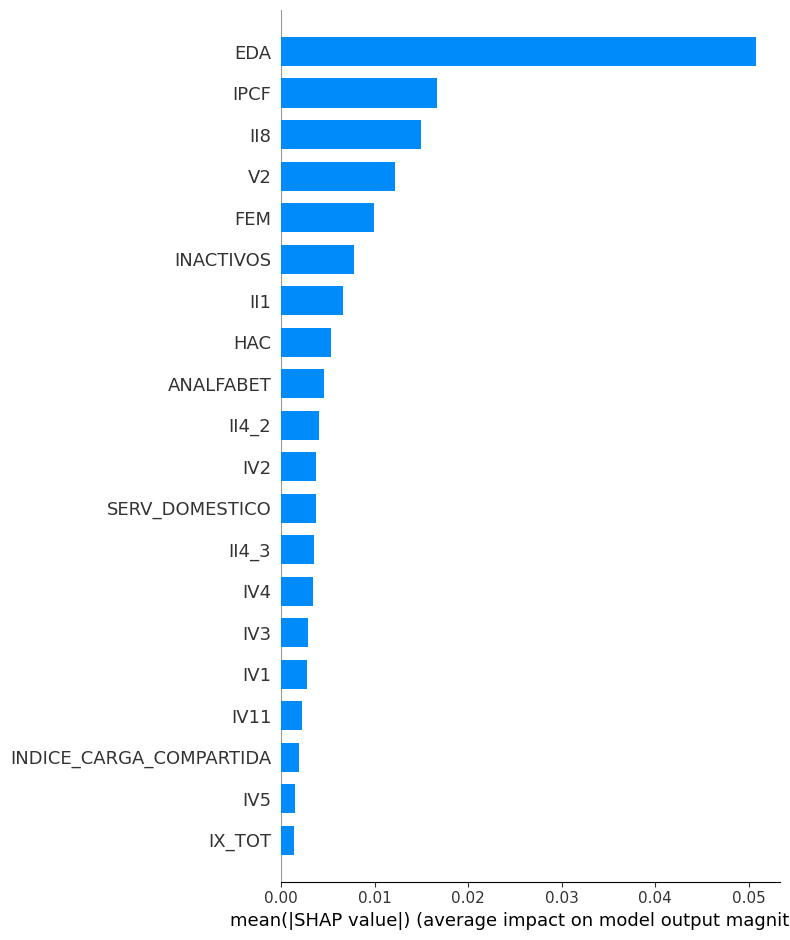

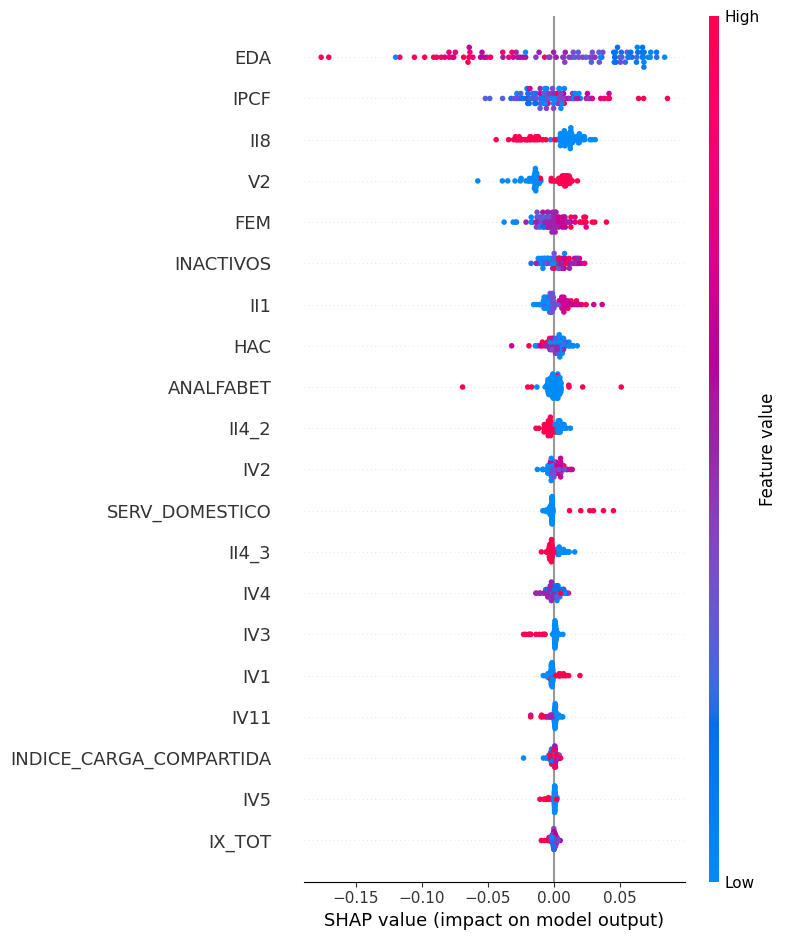

In [31]:
# ------------------------------------------------------------
# 11. Análisis de importancia de variables con SHAP (versión rápida)
# ------------------------------------------------------------
print("\nAnálisis de importancia de variables con SHAP (Random Forest - versión rápida):")

# Crear el explainer
explainer = shap.TreeExplainer(rf_model)

# Tomar una muestra representativa para análisis SHAP
X_sample = X_train.sample(n=100, random_state=0)

# Calcular los valores SHAP solo para esa muestra
shap_values = explainer.shap_values(X_sample)

# Gráfico de resumen: importancia media absoluta de cada variable
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# Gráfico detallado: dispersión y dirección del efecto
shap.summary_plot(shap_values, X_sample)

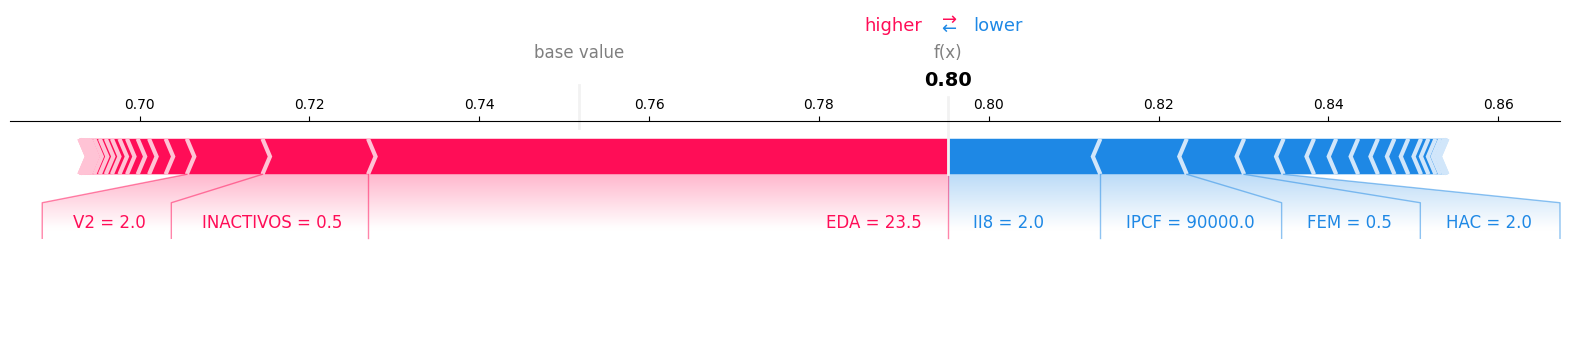

In [32]:
# Mostrar contribuciones para una observación específica
i = 0  # Cambiar el índice según el hogar de interés
shap.force_plot(explainer.expected_value, shap_values[i], X_sample.iloc[i], matplotlib=True)


Top 15 variables más importantes según SHAP (NE):
          Variable  SHAP_Importance
38             EDA         0.050786
1             IPCF         0.016663
23             II8         0.014995
26              V2         0.012133
39             FEM         0.009950
42       INACTIVOS         0.007821
16             II1         0.006670
33             HAC         0.005310
40       ANALFABET         0.004584
20           II4_2         0.004020
3              IV2         0.003726
35  SERV_DOMESTICO         0.003721
21           II4_3         0.003494
5              IV4         0.003451
4              IV3         0.002900


<Figure size 1000x600 with 0 Axes>

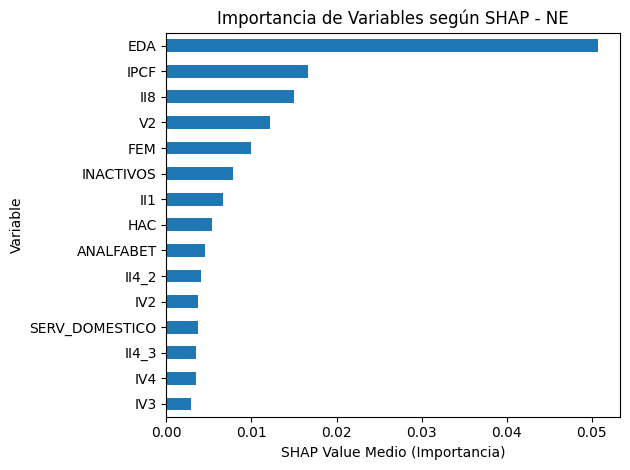

In [33]:
# ------------------------------------------------------------
# 12. Importancia promedio por SHAP values (top 15)
# ------------------------------------------------------------
shap_importance = pd.DataFrame({
    'Variable': X_train.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_Importance', ascending=False)

print("\nTop 15 variables más importantes según SHAP (NE):")
print(shap_importance.head(15))

# Visualización
plt.figure(figsize=(10, 6))
shap_importance.head(15).set_index('Variable').plot(kind='barh', legend=False)
plt.title("Importancia de Variables según SHAP - NE")
plt.xlabel("SHAP Value Medio (Importancia)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###4.3 Support Vector Regressor (SVR)

In [34]:
# ============================================================
# 13. Support Vector Regressor (SVR) para predicción de NE
# ============================================================

# ------------------------------------------------------------
# 13.1. Definición del modelo (pipeline con estandarización)
# ------------------------------------------------------------
svr_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1)
)

# ------------------------------------------------------------
# 13.2. Entrenamiento del modelo
# ------------------------------------------------------------
svr_model.fit(X_train, y_train)

# ------------------------------------------------------------
# 13.3. Predicción y evaluación
# ------------------------------------------------------------
y_pred_svr = svr_model.predict(X_test)

r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

# ------------------------------------------------------------
# 13.4. Actualización de tabla de resultados
# ------------------------------------------------------------
df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'SVR', 'R2': r2_svr, 'RMSE': rmse_svr}])
], ignore_index=True)

print("\nResultados incluyendo SVR:")
print(df_resultados)


Resultados incluyendo SVR:
         Modelo        R2      RMSE
0         Lasso  0.331299  0.118246
1         Ridge  0.331770  0.118205
2    ElasticNet  0.331281  0.118248
3  RandomForest  0.419851  0.110139
4           SVR  0.345829  0.116955


##5. Clasificacion
$${PE}_i = \mathbb{I}({NE}_i<\tau)$$

$\tau$: Mediana

###5.1 Regresión Logística

In [35]:
# ============================================================
# 14. Clasificación: Regresión Logística (Logit)
# ============================================================

# ------------------------------------------------------------
# 14.1. Crear variable binaria PE (por debajo de la mediana de NE)
# ------------------------------------------------------------
tau = df_modelo['NE'].median()
df_modelo['PE'] = (df_modelo['NE'] < tau).astype(int)

# ------------------------------------------------------------
# 14.2. Preparación de datos (X e y)
# ------------------------------------------------------------
columnas_excluidas_clasif = [
    'NE', 'PE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
    'EDA', 'FEM', 'ANALFABET', 'DESOCUP', 'INACTIVOS'
]


X = df_modelo.drop(columns=columnas_excluidas_clasif, errors='ignore')
y = df_modelo['PE']

# Variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Asegurar que todas las columnas sean numéricas
X = X.select_dtypes(include=[np.number])

# ------------------------------------------------------------
# 14.3. División en entrenamiento y prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# 14.4. Entrenamiento del modelo Logit (Regresión Logística)
# ------------------------------------------------------------
logit_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=0)
)

logit_model.fit(X_train, y_train)
y_pred_logit = logit_model.predict(X_test)

# ------------------------------------------------------------
# 14.5. Evaluación del modelo
# ------------------------------------------------------------
accuracy_logit = accuracy_score(y_test, y_pred_logit)
conf_mat_logit = confusion_matrix(y_test, y_pred_logit)
report_logit = classification_report(y_test, y_pred_logit)

print("\nResultados del modelo Logit (Regresión Logística):")
print(f"Exactitud (Accuracy): {accuracy_logit:.4f}")
print("\nMatriz de Confusión:")
print(conf_mat_logit)
print("\nReporte de Clasificación:")
print(report_logit)

# Extraer coeficientes del modelo logístico
modelo_logit = logit_model.named_steps['logisticregression']
coefs = pd.Series(modelo_logit.coef_[0], index=X.columns)

# Mostrar los 10 más importantes
print("\nTop 10 coeficientes (positivos y negativos):")
print(coefs.sort_values(key=abs, ascending=False).head(10))


Resultados del modelo Logit (Regresión Logística):
Exactitud (Accuracy): 0.6684

Matriz de Confusión:
[[1370  576]
 [ 737 1277]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68      1946
           1       0.69      0.63      0.66      2014

    accuracy                           0.67      3960
   macro avg       0.67      0.67      0.67      3960
weighted avg       0.67      0.67      0.67      3960


Top 10 coeficientes (positivos y negativos):
V2                        -0.651980
SERV_DOMESTICO            -0.423951
VII2_1                     0.280565
INDICE_CARGA_COMPARTIDA    0.243385
IV2                       -0.213100
IV1                       -0.204661
IPCF                      -0.195976
VII1_2                     0.184802
PERSONAS_TAREAS            0.180154
II8                        0.172901
dtype: float64


###5.1 Bosques aleatorios

In [36]:
# ============================================================
# 15. Clasificación: Random Forest Classifier con GridSearchCV
# ============================================================

# ------------------------------------------------------------
# 15.1. Preparación de datos (X e y)
# ------------------------------------------------------------
columnas_excluidas_clasif = [
    'NE', 'PE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
    'EDA', 'FEM', 'ANALFABET', 'DESOCUP', 'INACTIVOS'
]


X = df_modelo.drop(columns=columnas_excluidas_clasif, errors='ignore')
y = df_modelo['PE']

# Variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Asegurar solo variables numéricas
X = X.select_dtypes(include=[np.number])

# ------------------------------------------------------------
# 15.2. División entrenamiento / prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# 15.3. Definición de hiperparámetros y GridSearchCV
# ------------------------------------------------------------
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf_clf_base = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(
    estimator=rf_clf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ------------------------------------------------------------
# 15.4. Ajuste del modelo con búsqueda de grilla
# ------------------------------------------------------------
grid_search.fit(X_train, y_train)
best_rf_clf = grid_search.best_estimator_

# ------------------------------------------------------------
# 15.5. Evaluación del mejor modelo
# ------------------------------------------------------------
y_pred_best = best_rf_clf.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
conf_mat_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"\nExactitud (Accuracy): {accuracy_best:.4f}")
print("\nMatriz de Confusión:")
print(conf_mat_best)
print("\nReporte de Clasificación:")
print(report_best)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejores hiperparámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Exactitud (Accuracy): 0.6788

Matriz de Confusión:
[[1436  510]
 [ 762 1252]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1946
           1       0.71      0.62      0.66      2014

    accuracy                           0.68      3960
   macro avg       0.68      0.68      0.68      3960
weighted avg       0.68      0.68      0.68      3960




Análisis de importancia de variables con SHAP (Random Forest Classifier - PE):
Shape de shap_values_class1: (100, 44, 2)
Shape de X_sample_clf: (100, 44)


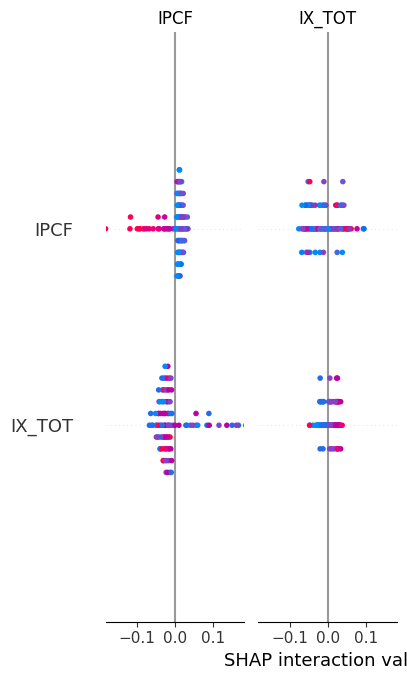

In [37]:
# ------------------------------------------------------------
# 16. Análisis de importancia de variables con SHAP (clasificación PE)
# ------------------------------------------------------------
print("\nAnálisis de importancia de variables con SHAP (Random Forest Classifier - PE):")

# Crear explainer con TreeExplainer
explainer_clf = shap.TreeExplainer(best_rf_clf)

# Muestra para acelerar (asegurando que tenga las mismas columnas que X_train)
X_sample_clf = X_train.sample(n=min(100, len(X_train)), random_state=0)

# Obtener valores SHAP (devuelve una lista por clase)
shap_values_clf = explainer_clf.shap_values(X_sample_clf)

# Verificar estructura de shap_values_clf
if isinstance(shap_values_clf, list):
    print(f"Número de clases: {len(shap_values_clf)}")
    shap_values_class1 = shap_values_clf[1]  # Asume clase PE=1
else:
    shap_values_class1 = shap_values_clf  # Caso para explainers sin lista por clase

# Verificar shapes
print(f"Shape de shap_values_class1: {shap_values_class1.shape}")
print(f"Shape de X_sample_clf: {X_sample_clf.shape}")

# Gráfico de resumen tradicional (solo si shapes coinciden)
if shap_values_class1.shape[1] == X_sample_clf.shape[1]:
    shap.summary_plot(shap_values_class1, X_sample_clf)
else:
    print("¡Error! Shapes no coinciden. Revisa las transformaciones de los datos.")


Top 15 variables más importantes según Permutation Importance (clasificación PE):
                   Variable  Importancia
26                       V2     0.090227
1                      IPCF     0.013131
0                    IX_TOT     0.007500
43  INDICE_CARGA_COMPARTIDA     0.002500
17                      II2     0.002374
23                      II8     0.002247
41           SERV_DOMESTICO     0.002247
16                      II1     0.002121
4                       IV3     0.001439
10                      IV9     0.001389
33                   VII1_1     0.001338
22                      II7     0.001288
5                       IV4     0.001263
20                    II4_2     0.001187
6                       IV5     0.001061


<Figure size 1000x600 with 0 Axes>

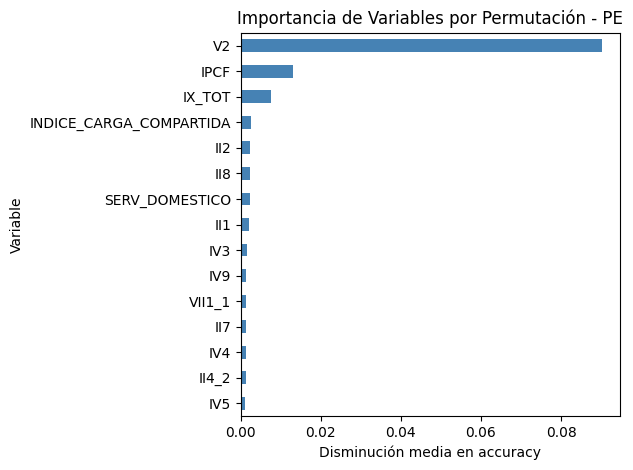

In [38]:
# ------------------------------------------------------------
# 17. Importancia de variables por Permutación (clasificación PE)
# ------------------------------------------------------------
from sklearn.inspection import permutation_importance

# Calcular importancia por permutación sobre el set de prueba
result = permutation_importance(
    best_rf_clf, X_test, y_test,
    n_repeats=10,
    random_state=0,
    n_jobs=-1
)

# Crear DataFrame con resultados
perm_importance_df = pd.DataFrame({
    'Variable': X_test.columns,
    'Importancia': result.importances_mean
}).sort_values(by='Importancia', ascending=False)

# Mostrar top 15
print("\nTop 15 variables más importantes según Permutation Importance (clasificación PE):")
print(perm_importance_df.head(15))

# Gráfico
plt.figure(figsize=(10, 6))
perm_importance_df.head(15).set_index('Variable').plot(
    kind='barh', legend=False, color='steelblue'
)
plt.title("Importancia de Variables por Permutación - PE")
plt.xlabel("Disminución media en accuracy")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###5.2 Support Vector Machine (SVM)

In [39]:
# ============================================================
# 18. Clasificación: Support Vector Machine (SVM)
# ============================================================

# ------------------------------------------------------------
# 1. Definición del modelo (pipeline con estandarización)
# ------------------------------------------------------------
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
)

# ------------------------------------------------------------
# 2. Entrenamiento del modelo
# ------------------------------------------------------------
svm_model.fit(X_train, y_train)

# ------------------------------------------------------------
# 3. Predicción y evaluación
# ------------------------------------------------------------
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

# ------------------------------------------------------------
# 4. Resultados
# ------------------------------------------------------------
print(f"Exactitud (Accuracy) SVM: {accuracy_svm:.4f}")
print("\nMatriz de Confusión (SVM):")
print(conf_mat_svm)
print("\nReporte de Clasificación (SVM):")
print(report_svm)

Exactitud (Accuracy) SVM: 0.6702

Matriz de Confusión (SVM):
[[1416  530]
 [ 776 1238]]

Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.65      0.73      0.68      1946
           1       0.70      0.61      0.65      2014

    accuracy                           0.67      3960
   macro avg       0.67      0.67      0.67      3960
weighted avg       0.67      0.67      0.67      3960



In [40]:
df_resultados_clasif = pd.DataFrame([
    {'Modelo': 'Logit', 'Accuracy': accuracy_logit},
    {'Modelo': 'Random Forest', 'Accuracy': accuracy_best},
    {'Modelo': 'SVM', 'Accuracy': accuracy_svm}
])
print(df_resultados_clasif)

          Modelo  Accuracy
0          Logit  0.668434
1  Random Forest  0.678788
2            SVM  0.670202
